In [64]:
# Load Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# Load combined dataset

# file directory
file= "../data/Air_Quality_Lagos_Combined.csv"

# load into DataFrame
df = pd.read_csv(file, index_col="date", parse_dates=True)

df.head()

,PM2.5
date,
2023-11-01 17:00:00+01:00,19.00
2023-11-01 18:00:00+01:00,3.25
2023-11-01 19:00:00+01:00,40.33
2023-11-01 20:00:00+01:00,40.33
2023-11-01 21:00:00+01:00,40.33


In [4]:
# Size of the Dataset
shape = df.shape

print(f"The Shape of the Dataset is: {shape}")
print(f"The Dataset has: {shape[0]} historical data")
print(f"The dataset have {shape[1]} column. For PM2.5 Readings")

The Shape of the Dataset is: (10902, 1)
The Dataset has: 10902 historical data
The dataset have 1 column. For PM2.5 Readings


In [13]:
# Data Split 

# train split
train = df.loc[:"2024-11-24"]

# test split
test = df.loc["2024-11-25":]

print(f"Train split: {train.shape}")
print(f"Test split: {test.shape}")

Train split: (8739, 1)
Test split: (2163, 1)


# AR (AutoRegressive) Model

In [35]:
# Fit the AR model
ar_model = AutoReg(train['PM2.5'], lags=24)  # for 24hours or 1 day
ar_result = ar_model.fit()

C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [36]:
# Model summary
ar_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                  PM2.5   No. Observations:                 8739
Model:                    AutoReg(24)   Log Likelihood              -33256.486
Method:               Conditional MLE   S.D. of innovations             10.991
Date:                Thu, 05 Jun 2025   AIC                          66564.971
Time:                        04:30:32   BIC                          66748.864
Sample:                            24   HQIC                         66627.646
                                 8739                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2074      0.228      5.302      0.000       0.761       1.654
PM2.5.L1       0.7533      0.011     70.376      0.000       0.732       0.774
PM2.5.L2       0.0200      0.013      1.490      0.136      -0.006       0.046
PM2.5.L3       0.0006      0.013      0.044      0.965      -0.026       0.027
PM2.5.L4       0.0473      0.013      3.533      0.000       0.021       0.074
PM2.5.L5       0.0481      0.013      3.587      0.000       0.022       0.074
PM2.5.L6      -0.0371      0.013     -2.769      0.006      -0.063      -0.011
PM2.5.L7       0.0155      0.013      1.154      0.249      -0.011       0.042
PM2.5.L8       0.0040      0.013      0.301      0.763      -0.022       0.030
PM2.5.L9       0.0251      0.013      1.869      0.062      -0.001       0.051
PM2.5.L10     -0.0089      0.013     -0.663      0.507      -0.035       0.017
PM2.5.L11      0.0156      0.013      1.168      0.243      -0.011       0.042
PM2.5.L12      0.0100      0.013      0.745      0.456      -0.016       0.036
PM2.5.L13     -0.0272      0.013     -2.035      0.042      -0.053      -0.001
PM2.5.L14      0.0575      0.013      4.297      0.000       0.031       0.084
PM2.5.L15     -0.0598      0.013     -4.462      0.000      -0.086      -0.034
PM2.5.L16      0.0318      0.013      2.372      0.018       0.006       0.058
PM2.5.L17     -0.0023      0.013     -0.173      0.863      -0.029       0.024
PM2.5.L18      0.0008      0.013      0.057      0.954      -0.026       0.027
PM2.5.L19     -0.0339      0.013     -2.524      0.012      -0.060      -0.008
PM2.5.L20      0.0093      0.013      0.692      0.489      -0.017       0.036
PM2.5.L21      0.0084      0.013      0.628      0.530      -0.018       0.035
PM2.5.L22      0.0322      0.013      2.402      0.016       0.006       0.058
PM2.5.L23      0.0177      0.013      1.324      0.185      -0.009       0.044
PM2.5.L24      0.0388      0.011      3.629      0.000       0.018       0.060
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             1.0092           -0.0000j            1.0092           -0.0000
AR.2             1.0400           -0.2343j            1.0661           -0.0353
AR.3             1.0400           +0.2343j            1.0661            0.0353
AR.4             0.9470           -0.5153j            1.0781           -0.0793
AR.5             0.9470           +0.5153j            1.0781            0.0793
AR.6             0.7846           -0.7755j            1.1032           -0.1241
AR.7             0.7846           +0.7755j            1.1032            0.1241
AR.8             0.5463           -0.9887j            1.1296           -0.1697
AR.9             0.5463           +0.9887j            1.1296            0.1697
AR

In [37]:
# Determine the correct integer-based start and end
start = len(train)
end = start + len(test) - 1

preds = ar_result.predict(start=start, end=end, dynamic=False)

# Reindex to match the test index
preds.index = test.index


C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


In [38]:
# Evaluation
mse = mean_squared_error(test['PM2.5'], preds)
mae = mean_absolute_error(test['PM2.5'], preds)

print(f"AR Model - MSE: {mse:.2f}")
print(f"AR Model - MAE: {mae:.2f}")

AR Model - MSE: 259.62
AR Model - MAE: 10.67


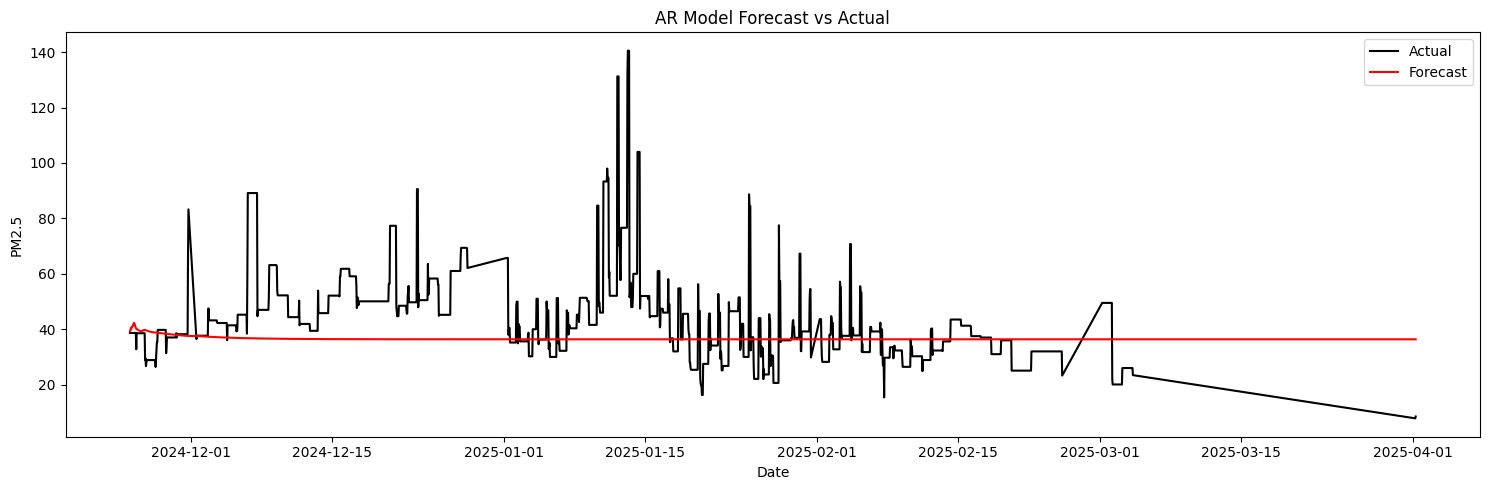

In [39]:
# Plot results
plt.figure(figsize=(15, 5))
plt.plot(test['PM2.5'], label="Actual", color='black')
plt.plot(preds, label="Forecast", color='red')
plt.title("AR Model Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("PM2.5")
plt.legend()
plt.tight_layout()
plt.show()

## Summary

The AR model Underperformed. why:
- The forecast (red line) is almost flat, failing to capture the volatility, spikes, and seasonality in the test set.
- AR models rely only on past values of the series (lags) and assume a linear relationship, which often fails when: There’s strong seasonality or nonlinearity.
- Residuals are not white noise, as we saw earlier from decomposition and ACF plots.



# ARMA (AutoRegressive Moving Average) Model

In [40]:
# 1st order differencing
diff_train = train['PM2.5'].diff().dropna()


In [57]:
# Fit ARMA(p=2, q=2) on differenced data (you can tune p and q later)
arma_model = ARIMA(train['PM2.5'], order=(2, 0, 2))  # d=0 because we assume stationary (you can test d=1 if needed)
arma_result = arma_model.fit()

C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [53]:
arma_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  PM2.5   No. Observations:                 8739
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -33437.154
Date:                Thu, 05 Jun 2025   AIC                          66884.308
Time:                        04:41:50   BIC                          66919.685
Sample:                             0   HQIC                         66896.363
                               - 8739                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1193      0.212     -0.564      0.573      -0.534       0.295
ar.L2          0.6064      0.148      4.087      0.000       0.316       0.897
ma.L1         -0.1050      0.212     -0.495      0.621      -0.521       0.311
ma.L2         -0.7870      0.198     -3.978      0.000      -1.175      -0.399
sigma2       123.3869      0.263    469.221      0.000     122.871     123.902
===================================================================================
Ljung-Box (L1) (Q):                   1.20   Jarque-Bera (JB):           7182808.75
Prob(Q):                              0.27   Prob(JB):                         0.00
Heteroskedasticity (H):               0.25   Skew:                             4.08
Prob(H) (two-sided):                  0.00   Kurtosis:                       143.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [54]:
# Forecast
start = len(train)
end = start + len(test) - 1
preds = arma_result.predict(start=start, end=end, dynamic=False)
preds.index = test.index

C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [55]:
# Evaluation
mse = mean_squared_error(test['PM2.5'], preds)
mae = mean_absolute_error(test['PM2.5'], preds)

print(f"ARMA Model - MSE: {mse:.2f}")
print(f"ARMA Model - MAE: {mae:.2f}")

ARMA Model - MSE: 228.62
ARMA Model - MAE: 10.24


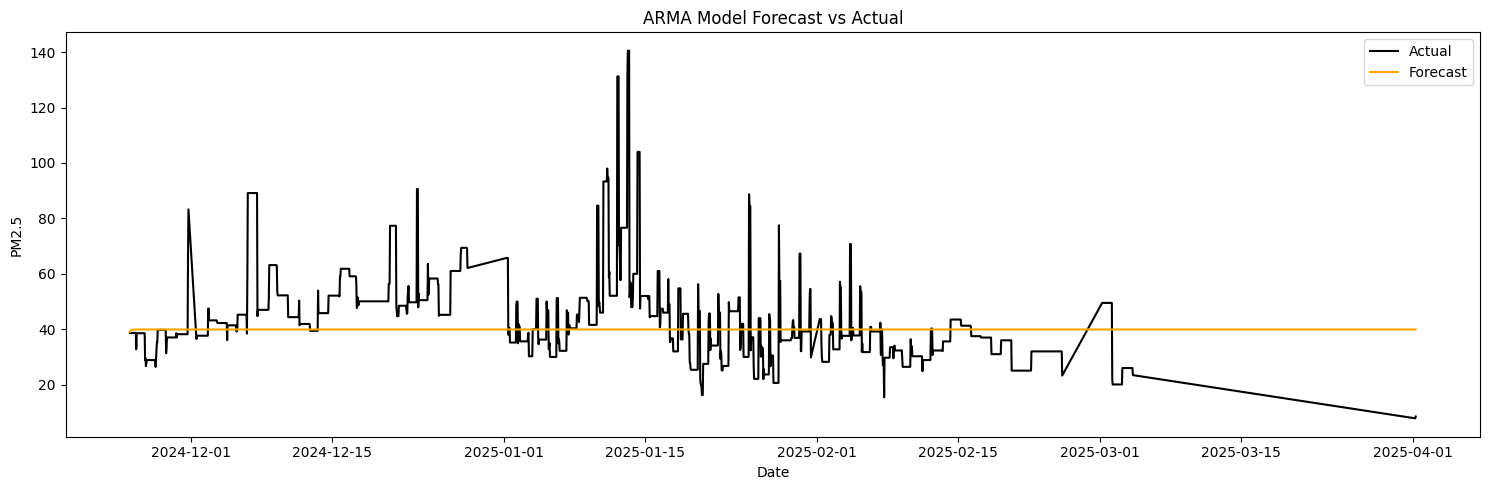

In [56]:
# Plot
plt.figure(figsize=(15, 5))
plt.plot(test['PM2.5'], label="Actual", color='black')
plt.plot(preds, label="Forecast", color='orange')
plt.title("ARMA Model Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("PM2.5")
plt.legend()
plt.tight_layout()
plt.show()

# ARIMA MODEL

In [58]:
# Fit ARIMA
arima_model = ARIMA(train['PM2.5'], order=(2, 1, 2))  # d=1 for first-order differencing
arima_result = arima_model.fit()

C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [60]:
# Forecast
start = len(train)
end = start + len(test) - 1
preds = arima_result.predict(start=start, end=end, typ="levels")  # 'levels' because we differenced the series

# Align index
preds.index = test.index



C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [61]:
# Evaluation
mse = mean_squared_error(test['PM2.5'], preds)
mae = mean_absolute_error(test['PM2.5'], preds)

print(f"ARIMA Model - MSE: {mse:.2f}")
print(f"ARIMA Model - MAE: {mae:.2f}")


ARIMA Model - MSE: 228.62
ARIMA Model - MAE: 10.24


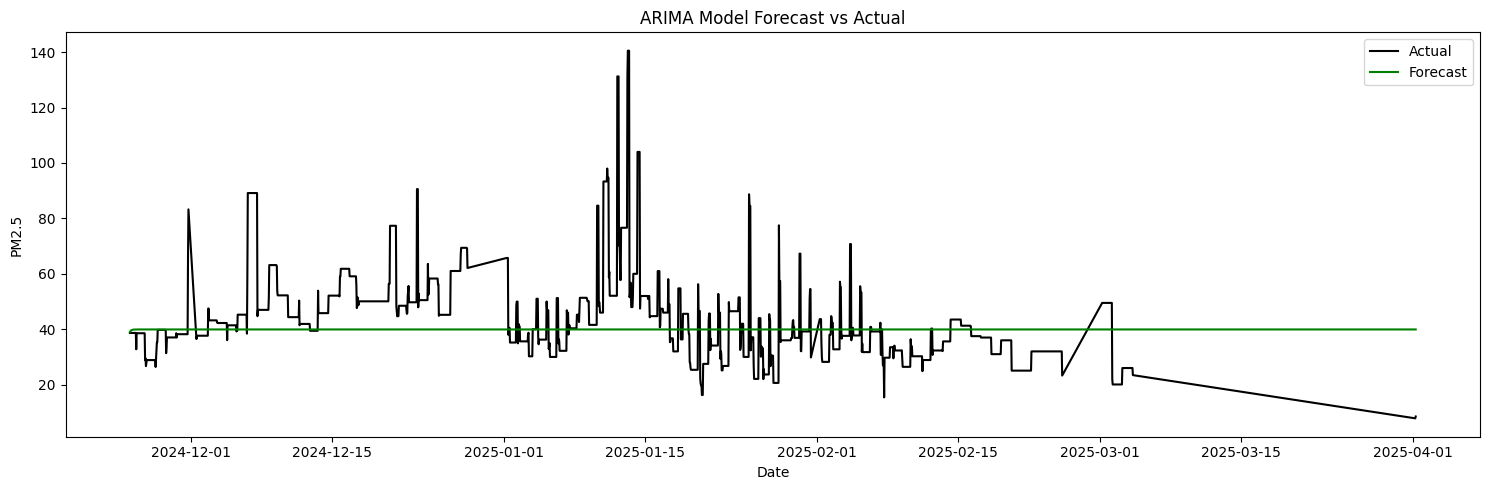

In [63]:
# Plot
plt.figure(figsize=(15, 5))
plt.plot(test['PM2.5'], label="Actual", color='black')
plt.plot(preds, label="Forecast", color='green')
plt.title("ARIMA Model Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("PM2.5")
plt.legend()
plt.tight_layout()
plt.show()

# SARIMA (Seasonal ARIMA) Model

In [ ]:
# Fit SARIMA
sarima_model = SARIMAX(train['PM2.5'],
                       order=(2, 1, 2),
                       seasonal_order=(1, 1, 1, 168),
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarima_result = sarima_model.fit()


In [67]:
# Find start and end positions for test set in full data
start_idx = len(train)
end_idx = len(train) + len(test) - 1

# Forecast using integer positions
sarima_preds = sarima_result.predict(start=start_idx, end=end_idx, dynamic=False)

# Align index to test set for plotting
sarima_preds.index = test.index


C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [68]:
# Evaluation
mse = mean_squared_error(test['PM2.5'], sarima_preds)
mae = mean_absolute_error(test['PM2.5'], sarima_preds)

print(f"SARIMA Model - MSE: {mse:.2f}")
print(f"SARIMA Model - MAE: {mae:.2f}")

SARIMA Model - MSE: 627.60
SARIMA Model - MAE: 19.76


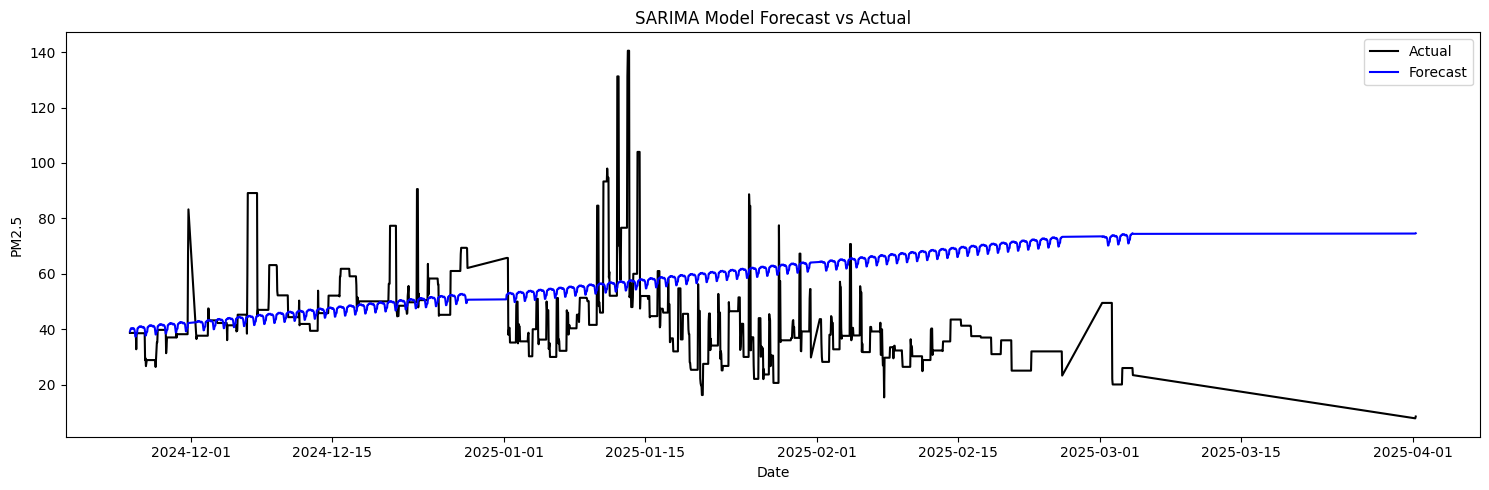

In [70]:
# Plot
plt.figure(figsize=(15, 5))
plt.plot(test['PM2.5'], label="Actual", color='black')
plt.plot(sarima_preds, label="Forecast", color='blue')
plt.title("SARIMA Model Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("PM2.5")
plt.legend()
plt.tight_layout()
plt.show()